# 3. Dimensionality reduction

This tutorial on reducing the dimension of the scattering coefficients using an
independent component analysis. In this Jupyter notebook, we will walk through
the process of extracting the most relevant features in order to use them later
for clustering. We here follow again the indications in Steinmann et al.
([2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455))
but we advise that many other methods for reducing the dimensions may be
relevant for other datasets. 

Made in 2022 by René Steinmann and Léonard Seydoux.

This notebook uses the __matplotlib__ and __scikit-learn__ library, please run the cell below if the packages are not installed.

In [62]:
# %pip install matplotlib
# %pip install scikit-learn

In [63]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA

plt.rcParams["date.converter"] = "concise"

## Load scattering coefficients

First, we load the scattering coefficients and reshape them for any [dimensionality reduction](https://scikit-learn.org/stable/modules/unsupervised_reduction.html) model (here `FastICA`) of the `scikit-learn` package. The shape of the scattering coefficients are given by the following tuples:

- Order 1: `(n_times, n_channel, octaves[0] * resolution[0])`
- Order 2: `(n_times, n_channel, octaves[0] * octaves[1] * resolution[0]  *
  resolution[1])`
- ...
- Order n: `(n_times, n_channel, np.prod(octaves) * np.prod(resolution))`

We then need to collect the all-order scattering coefficients into a
two-dimensional matrix for use with Scikit Learn. 

> Note that the optimal way to load the scattering coefficients is to use `xarray` 

In [64]:
# Load data from file
with np.load("../example/GL_scattering_coefficients_20s.npz", allow_pickle=True) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

seg_duration = 2 * np.unique(np.diff(times))[0].seconds # seconds, assuming 50% overlap
print('Segment duration is {} s'.format(seg_duration))

Collected 8638 samples of 528 dimensions each.
Segment duration is 20 s


## Extract independant features

After loading and stacking the scattering coefficients into a matrix, we can now apply a dimentionality reduction algorithm. We here use the `FastICA` algorithm, but highly recommend to try other algorithms that will allow to proceed in the most adapted way to the data at hand. 

The `FastICA` algorithm looks for a matrix factorization with independent sources, and a mixing matrix. We need to inform the model about how many components (or features) we want to extract in the `n_components` keyword argument  below. The residual shape of the `features` matrix will be `(n_times, n_components)` instead of the initial scattering coefficients shape shown above.

In [65]:
n_components=5
model = FastICA(n_components=n_components, whiten="unit-variance")
features = model.fit_transform(scattering_coefficients)

### Save the output

We here save the extracted features scattering coefficients as a npz-file, like the scattering coefficients in the previous notebook.

In [66]:
# Save the features
np.savez(
    "../example/GL_independent_components.npz",
    features=features,
    times=times,
)

# Save the dimension reduction model
with open("../example/GL_dimension_model.pickle", "wb") as pickle_file:
    pickle.dump(
        model,
        pickle_file,
        protocol=pickle.HIGHEST_PROTOCOL,
    )

### Have a look at the features

This is a crucial step: do you see structure in the independent components, or do they seem all random? Do the structures correlate with the a priori information at your disposal or to identifiable signal structures? At this stage, it is important to carefully address those questions. The optimal solution may not be to use the `FastICA` model depending on the data at hand, although it can be adapated to many datasets. Playing with the number of components can also be an important way of creating structure in the output.

Features are weights. - Tim

In [67]:
# for f in features.T:
#     fig, ax = plt.subplots(1)
#     ax.plot(f, rasterized=True)

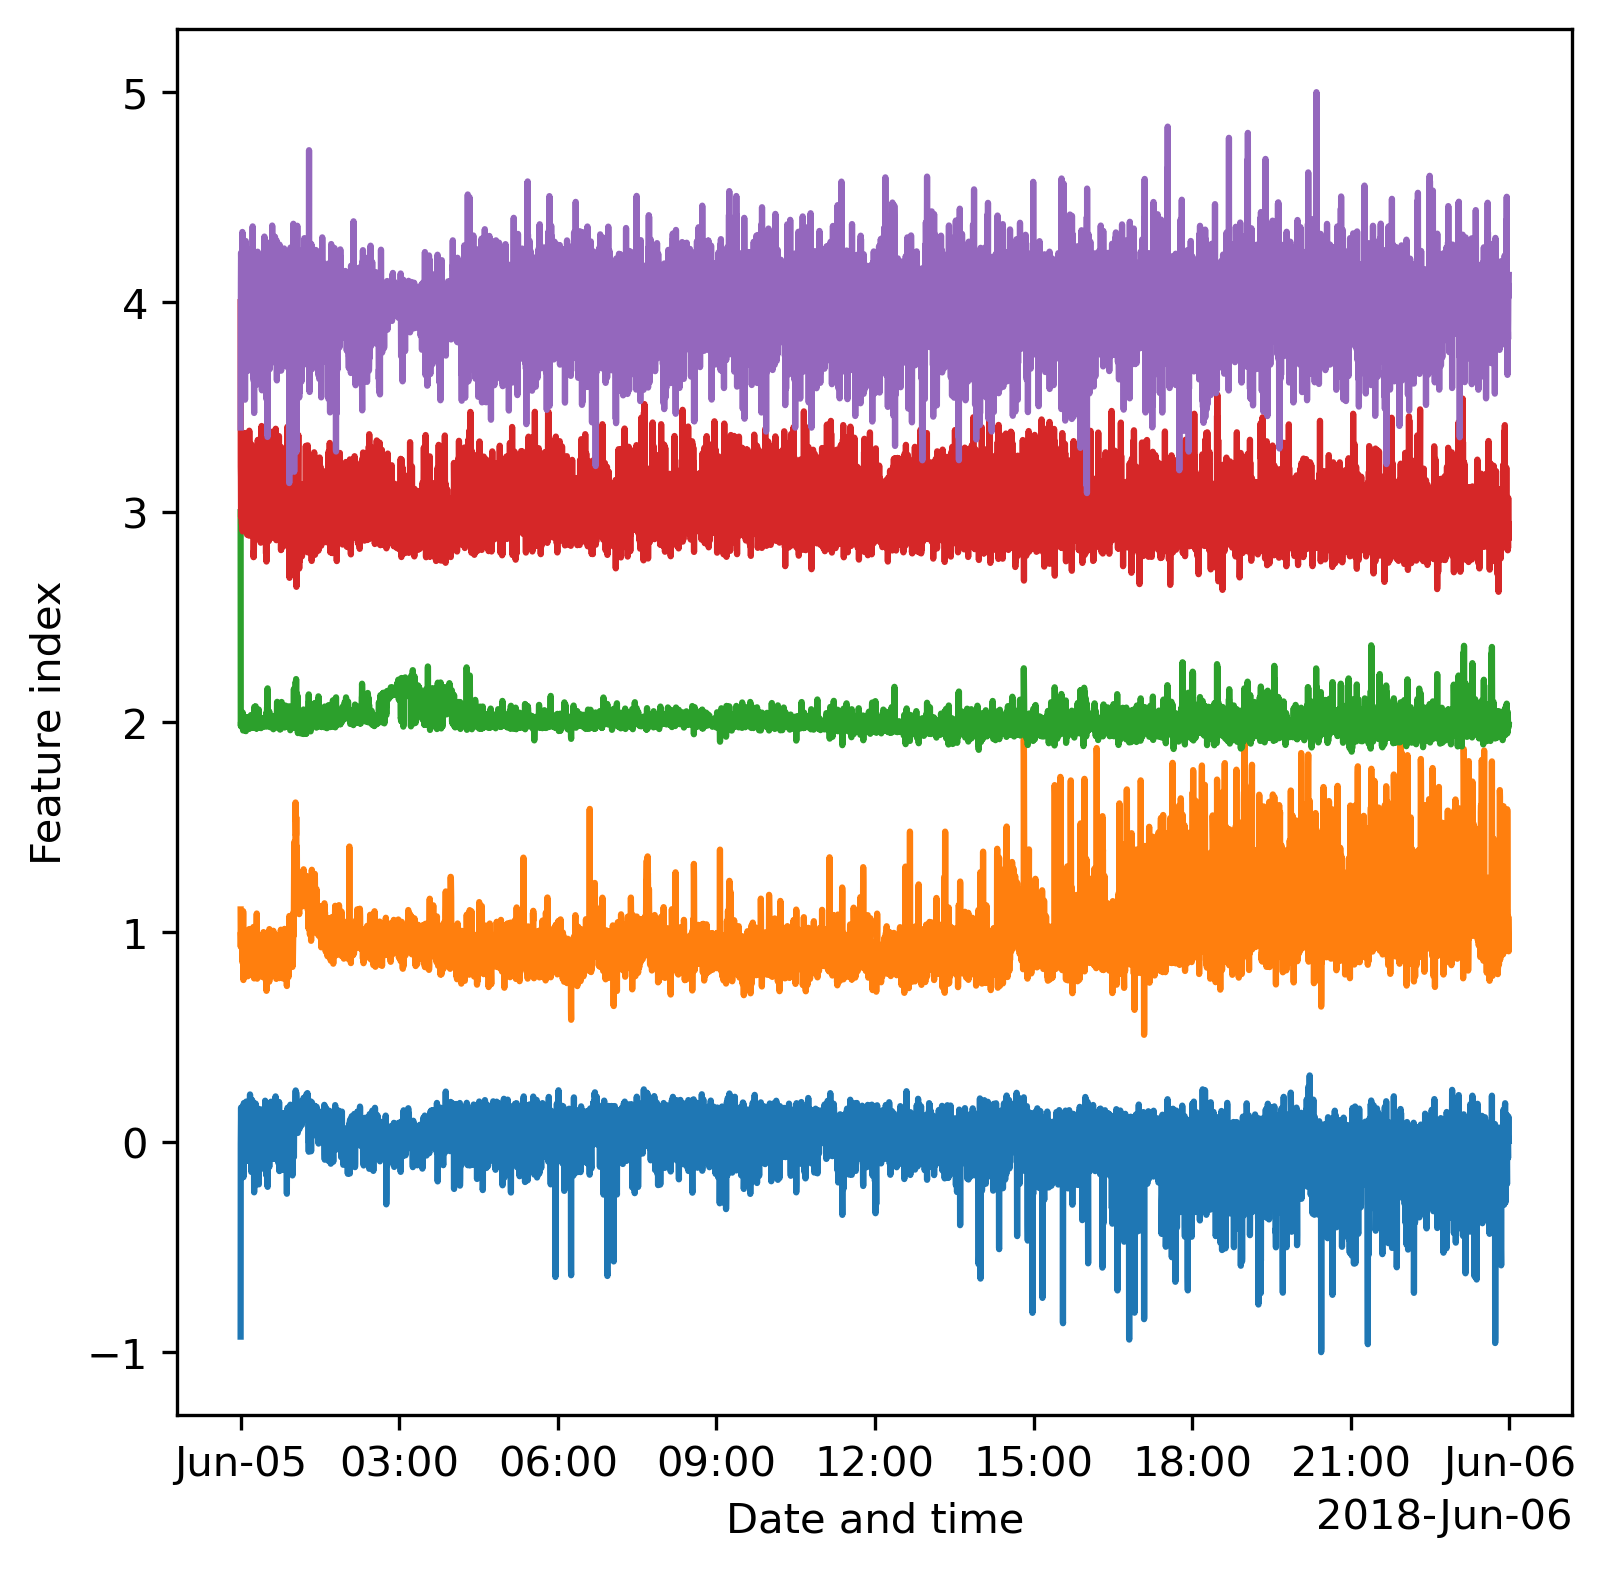

In [68]:
# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=300, figsize=[6,6])
ax = plt.axes()

# Plot features
ax.plot(times[:-1], features_normalized + 1*np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel("Date and time")

# Show
plt.savefig('figures/feature_ts_{:0>2d}f_{}s_{}'.format(n_components, seg_duration, np.datetime64('today')))
plt.show()


In [56]:
model
print(features.shape)
type(features)

(8638, 5)


numpy.ndarray

In [61]:
print(type(model))
print(model)
print(dir(model))

<class 'sklearn.decomposition._fastica.FastICA'>
FastICA(n_components=5, whiten='unit-variance')
['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_check_feature_names', '_check_n_features', '_fit_transform', '_get_param_names', '_get_tags', '_more_tags', '_n_features_out', '_parameter_constraints', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_sklearn_auto_wrap_output_keys', '_unmixing', '_validate_data', '_validate_params', '_whiten', 'algorithm', 'components_', 'fit', 'fit_transform', 'fun', 'fun_args', 'get_feature_names_out', 'get_params', 'inverse_transform', 'max_iter', 'mean_', 'mixing_', 'n_components', 'n_f